In [71]:
import sys
sys.path.append('/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/dhnlplotting/util')

import glob
import os
from plot_base import PlotBase
from IPython.display import display, Image
import ROOT
ROOT.gROOT.SetStyle("ATLAS")
from array import array
import importlib
import plot_base
import plot_util
import numpy as np
importlib.reload(plot_base)
importlib.reload(plot_util)

# ____________________________________________________________
# Get histograms

displaced_lepton_syst_d0_bins = [0, 3, 10, 20, 30, 40, 50, 60]
bins = array('f', displaced_lepton_syst_d0_bins)
nbins = len(bins) - 1
overflow_bin = nbins + 1

try:
    for obj_name in ["h_abs_d0_all_el", "h_abs_d0_selected_el", "h_abs_d0_all_mu", "h_abs_d0_selected_mu"]:
        ROOT.gROOT.FindObject(obj_name).Delete()
except:
    pass

el_denom = ROOT.TH1F("h_abs_d0_all_el","All electrons", nbins, bins) 
el_num = ROOT.TH1F("h_abs_d0_selected_el","Selected Electrons", nbins, bins) 
mu_denom = ROOT.TH1F("h_abs_d0_all_mu","All muons", nbins, bins) 
mu_num = ROOT.TH1F("h_abs_d0_selected_mu","Selected muons", nbins, bins) 
# print(mu_denom)
trees = []

var_name = 'd0'
# var_name = 'd0_truth'

for filename in glob.glob('/data/hnl/histograms/v9p3_histograms_OS/histograms_mc16a_?ee_*.root') + glob.glob('/data/hnl/histograms/v9p3_histograms_OS/histograms_mc16a_?uu_*.root'):
# for filename in glob.glob('/data/hnl/histograms/v9p3_histograms_OS/histograms_mc16a_?uu_*.root'):
# for filename in glob.glob('/data/hnl/histograms/v5p0_histograms/histograms_mc16a_*_10G_10mm.root'):
    for f in [
        filename, 
        filename.replace('mc16a', 'mc16d'), 
        filename.replace('mc16a', 'mc16e'), 
        ]: 
        if var_name == 'd0_truth' and 'mc16a' in f:
            continue # Truth d0 is NAN for mc16a for some reason. Causes overflow issues.
        if not os.path.isfile(f):
            print('missing', f)
            continue
        tfile = ROOT.TFile(f)
        tfile.cd()
        trees.append(tfile)

        for treename in [
            # 'nominal_VSI_LeptonsMod_ntuples_LNC_plus_LNV_mHNL',
            'nominal_VSI_LeptonsMod_ntuples_LNC_plus_LNV_OS',
            ]:
            tree = tfile.Get(treename)
            if tree == None: 
                break
            trees.append(tree)

            # truth matching requirement
            truth_matched_requirement = '(DV_truth_matched>=1)'
            pt_0_requirement = '*(DV_trk_0_pt>20.0)'
            pt_1_requirement = pt_0_requirement.replace('trk_0_pt', 'trk_1_pt')
            # truth_matched_requirement = '1'

            # denom
            abs_d0_all_lep0 = ROOT.TH1F("h_abs_d0_all_lep0","h_abs_d0_all_lep0", nbins, bins)
            tree.Draw(f"abs(DV_trk_0_{var_name})>>h_abs_d0_all_lep0",truth_matched_requirement+pt_0_requirement, "")
            abs_d0_all_lep1 = ROOT.TH1F("h_abs_d0_all_lep1","h_abs_d0_all_lep1", nbins, bins)
            tree.Draw(f"abs(DV_trk_1_{var_name})>>h_abs_d0_all_lep1",truth_matched_requirement+pt_1_requirement, "")

            # both are muons
            if 'uuu' in f or 'euu' in f: 
                mu_denom.Add(abs_d0_all_lep0)
                mu_denom.Add(abs_d0_all_lep1)
                quality_requirement_0 = '(DV_mumu>=1)'+'*'+truth_matched_requirement+pt_0_requirement
                quality_requirement_1 = '(DV_mumu>=1)'+'*'+truth_matched_requirement+pt_1_requirement

            # both are electrons
            if 'eee' in f or 'uee' in f: 
                el_denom.Add(abs_d0_all_lep0)
                el_denom.Add(abs_d0_all_lep1)
                quality_requirement_0 = '(DV_ee>=1)'+'*'+truth_matched_requirement+pt_0_requirement
                quality_requirement_1 = '(DV_ee>=1)'+'*'+truth_matched_requirement+pt_1_requirement

            if 'uue' in f or 'eeu' in f: # in mixed DVs
                mu_denom.Add(abs_d0_all_lep0) # lep0 is always the muon
                el_denom.Add(abs_d0_all_lep1) # lep1 is always the electron
                quality_requirement_0 = '(DV_emu>=1)'+'*'+truth_matched_requirement+pt_0_requirement
                quality_requirement_1 = '(DV_emu>=1)'+'*'+truth_matched_requirement+pt_1_requirement

            # num
            abs_d0_sel_lep0 = ROOT.TH1F("h_abs_d0_sel_lep0", "h_abs_d0_sel_lep0", nbins, bins) 
            tree.Draw(f"abs(DV_trk_0_{var_name})>>h_abs_d0_sel_lep0", quality_requirement_0, "")
            abs_d0_sel_lep1 = ROOT.TH1F("h_abs_d0_sel_lep1", "h_abs_d0_sel_lep1", nbins, bins)
            tree.Draw(f"abs(DV_trk_1_{var_name})>>h_abs_d0_sel_lep1", quality_requirement_1, "")

            if 'uuu' in f or 'euu' in f:
                mu_num.Add(abs_d0_sel_lep0)
                mu_num.Add(abs_d0_sel_lep1)
            if 'eee' in f or 'uee' in f:
                el_num.Add(abs_d0_sel_lep0)
                el_num.Add(abs_d0_sel_lep1)
            if 'uue' in f or 'eeu' in f: 
                mu_num.Add(abs_d0_sel_lep0) 
                el_num.Add(abs_d0_sel_lep1)

            ROOT.gROOT.FindObject("h_abs_d0_sel_lep0").Delete()
            ROOT.gROOT.FindObject("h_abs_d0_sel_lep1").Delete()
            ROOT.gROOT.FindObject("h_abs_d0_all_lep0").Delete()
            ROOT.gROOT.FindObject("h_abs_d0_all_lep1").Delete()
        # for treename
        tfile.Close()
    # for f
    # break
# for filename

print(el_num, el_num.GetEntries())
print(mu_num, mu_num.GetEntries())
print(el_denom, el_denom.GetEntries())
print(mu_denom, mu_denom.GetEntries())

# move overflow content into last visible bin
for h in [el_denom, el_num, mu_denom, mu_num]:
    # print( h[overflow_bin-1], '+', h[overflow_bin])
    h.SetBinContent(overflow_bin-1, h[overflow_bin-1] + h[overflow_bin])
    h.SetBinContent(overflow_bin, 0)  



Name: h_abs_d0_selected_el Title: Selected Electrons NbinsX: 7 17734.0
Name: h_abs_d0_selected_mu Title: Selected muons NbinsX: 7 42524.0
Name: h_abs_d0_all_el Title: All electrons NbinsX: 7 18080.0
Name: h_abs_d0_all_mu Title: All muons NbinsX: 7 43339.0


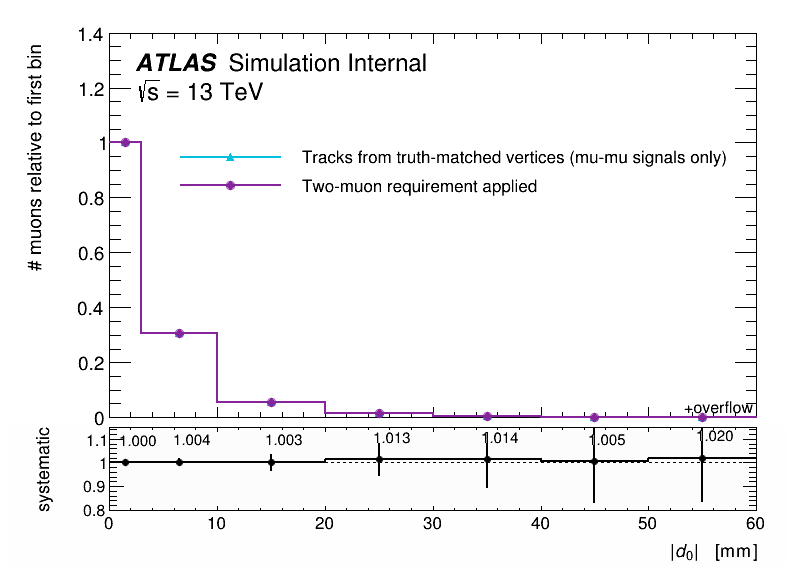

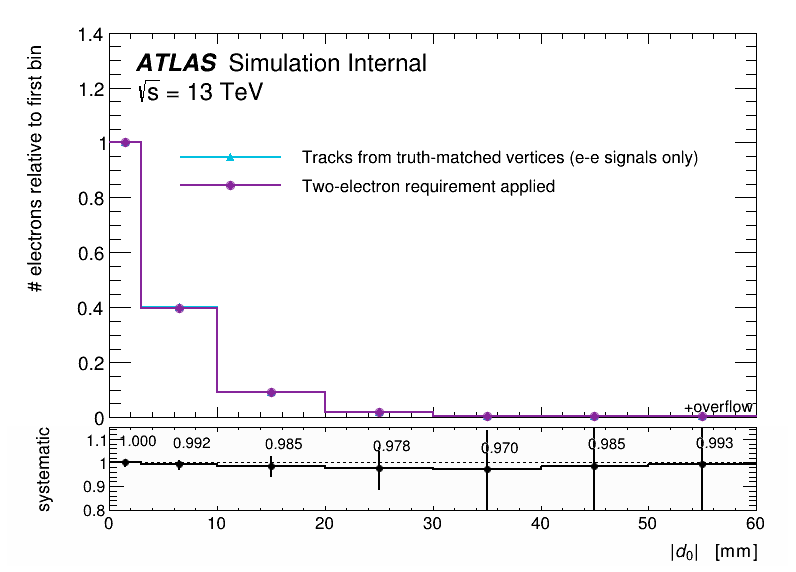

Info in <TCanvas::Print>: png file /home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/d0_extrapolation/plots/png//d0_muon.png has been created
Info in <TCanvas::Print>: eps file /home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/d0_extrapolation/plots/eps//d0_muon.eps has been created
Info in <TCanvas::Print>: png file /home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/d0_extrapolation/plots/png//d0_electron.png has been created
Info in <TCanvas::Print>: eps file /home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/d0_extrapolation/plots/eps//d0_electron.eps has been created


In [72]:
# ____________________________________________________________
# define plotting class

class Hist1DRatio(PlotBase):
    def __init__(self, num, denom, lepton, **kwargs):
        super(Hist1DRatio, self).__init__(
                        # x1    y1    x2    y2
            legend_loc = [0.2, 0.65, 0.92, 0.75],
            atlas_loc = [0.17, 0.875],
            extra_lines_loc = [0.17,0.775],
            x_title = '\ |d_0|',
            x_units = 'mm',
            norm = 1,
            atlas_mod = 'Simulation Internal',

            )

        # Get histograms (need to return file too because ROOT is ... ROOT)
        # num, denom = get_histograms(filename, lepton)

        self.hists = [num, denom]
        self.lepton = lepton
        self.pad_empty_space(self.hists)
        self.ratio_ymin = 0.8
        self.ratio_ymax = 1.15
        purple = ROOT.TColor().GetColor("#86259B")
        blue = ROOT.TColor().GetColor("#01C0E0")
        self.colors = [purple, blue]
        self.markers = [20, 22]

        # self.extra_legend_lines = [lepton]
        self._make_decorations()
        self.y_title = f'# {lepton}s relative to first bin'

        self.set_titles(num)
        self.set_titles(denom)

        for i, h in enumerate(self.hists):
            h.SetMarkerColor( self.colors[i] )
            h.SetMarkerStyle( self.markers[i] )
            h.SetMarkerSize( 1.2 )
            # if hist_type == "uuu_10mm":
            #   h.SetFillColor( color_dict[hist_type] )
            h.SetLineColor( self.colors[i] )

            h.SetLineWidth(2)
            h.GetXaxis().SetTitleOffset(1.2)
            h.GetYaxis().SetTitleOffset(1.2)
            h.GetXaxis().SetTitleSize(.05)
            h.GetYaxis().SetTitleSize(.05)
            h.GetXaxis().SetLabelSize(.05)
            h.GetYaxis().SetLabelSize(.05)
            h.GetXaxis().SetLabelOffset(0.01)

        ratio = num.Clone()
        ratio.Sumw2()
        
        ratio.Divide(denom)

        first_bin = ratio.GetBinContent(1)
        for i in range(1, int(ratio.GetEntries())):
            ratio.SetBinContent(i, ratio.GetBinContent(i)/first_bin)

        # ratio.GetYaxis().SetTitle("Data/MC")
        ratio.GetYaxis().SetTitle("systematic")
        ratio.SetMarkerColor(ROOT.kBlack)
        ratio.SetLineColor(ROOT.kBlack)

        ratio.SetMarkerColor(ROOT.kBlack)
        ratio.SetLineColor(ROOT.kBlack)
        ratio.GetXaxis().SetTitleOffset(1.3)
        ratio.GetYaxis().SetTitleOffset(.37)
        ratio.GetXaxis().SetTitleSize(.14)
        ratio.GetYaxis().SetTitleSize(.14)
        ratio.GetXaxis().SetLabelSize(0.135)
        ratio.GetXaxis().SetLabelOffset(0.03)
        ratio.GetYaxis().SetLabelSize(0.125)
        ratio.GetYaxis().SetNdivisions(505)
        ratio.SetMarkerSize(0.9)

        pad1, pad2 = plot_util.format_2pads_for_ratio(self.canvas)
        num.GetXaxis().SetLabelOffset(0.05)
        denom.GetXaxis().SetLabelOffset(0.05)

        pad1.Draw()
        pad2.Draw()

        pad1.cd()
        if (self.log_scale_y):
            pad1.SetLogy()

        # scale = 1/denom.Integral()
        scale = 1/denom.GetBinContent(1) # scale denominator to first bin
        denom.Scale(scale)
        scale = 1/num.GetBinContent(1) # scale numerator to first bin
        num.Scale(scale)

        self.y_max = denom.GetBinContent(1)*1.4
        self.set_y_axis_bounds(num)
        self.set_y_axis_bounds(denom)

        self.determine_y_axis_title(num, f'{lepton}s')
        self.determine_y_axis_title(denom, f'{lepton}s')

        denom.Draw("hist E")
        num.Draw("hist E same")

        # overflow label
        last_bin = denom.GetNbinsX()
        text = ROOT.TLatex()
        text.SetTextAlign(21)
        text.SetTextColor(ROOT.kBlack)
        text.SetTextSize(0.042)
        text.DrawLatex(denom.GetXaxis().GetBinCenter(last_bin)+1.5, denom.GetBinContent(last_bin)+.015, '+overflow')

        pad1.Update()

        pad2.cd()
        ratio.SetMinimum(self.ratio_ymin)
        ratio.SetMaximum(self.ratio_ymax)
        ratio.Draw("hist E")
        ratio.GetXaxis().SetTitle("\ |d_0|~\mbox{[mm]}")
        # ratio.Draw("text same ")
        
        # line
        line = ROOT.TLine(ratio.GetXaxis().GetXmin(),1,ratio.GetXaxis().GetXmax(),1)
        line.SetLineColor(ROOT.kBlack)
        line.SetLineWidth(1)
        line.SetLineStyle(2)
        line.Draw("same")

        # legend
        if lepton == 'muon':
            self.leg.AddEntry(denom, 'Tracks from truth-matched vertices (mu-mu signals only)')
            self.leg.AddEntry(num,'Two-muon requirement applied')
        if lepton == 'electron':
            self.leg.AddEntry(denom, 'Tracks from truth-matched vertices (e-e signals only)')
            self.leg.AddEntry(num,'Two-electron requirement applied')

        pad2.cd()

        text = ROOT.TLatex()
        text.SetTextAlign(21)
        text.SetTextColor(ROOT.kBlack)
        text.SetTextSize(0.12)
        for j in range(ratio.GetNbinsX()+1):
            x  = ratio.GetXaxis().GetBinCenter(j)
            y  = ratio.GetBinContent(j)
            if y != 0.0: 
                text.DrawLatex(x+1.3, max(self.ratio_ymin, y)+.07, f'{y:.3f}')

        self.canvas.Update()
        self.canvas.Modified()
        self.print_to_file('/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/d0_extrapolation/plots/png/',f'/d0_{lepton}.png')
        self.print_to_file('/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/d0_extrapolation/plots/eps/',f'/d0_{lepton}.eps')
        ratio.SetDirectory(0)
        pad1.Close()
        pad2.Close()
        self.canvas.Close()

        self.ratio = ratio
        self.num = num
        self.denom = denom


h_muon = Hist1DRatio(mu_num, mu_denom, 'muon')
display(Image(filename=f'/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/d0_extrapolation/plots/png/d0_{h_muon.lepton}.png'));
h_electron = Hist1DRatio(el_num, el_denom, 'electron')
display(Image(filename=f'/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/d0_extrapolation/plots/png/d0_{h_electron.lepton}.png'));


In [40]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
df = uproot.open('/data/hnl/histograms/v9p3_histograms_OS/histograms_mc16a_uue_20G_10mm.root')['nominal_VSI_LeptonsMod_ntuples_LNC_plus_LNV_OS'].pandas.df(['DV_trk_0_pt', 'DV_trk_1_pt'])
df.hist(bins=np.linspace(0,50,10))
plt.show()

DV_trk_0_pt    20.596264
DV_trk_1_pt     8.553501
dtype: float64

/home/newhouse/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


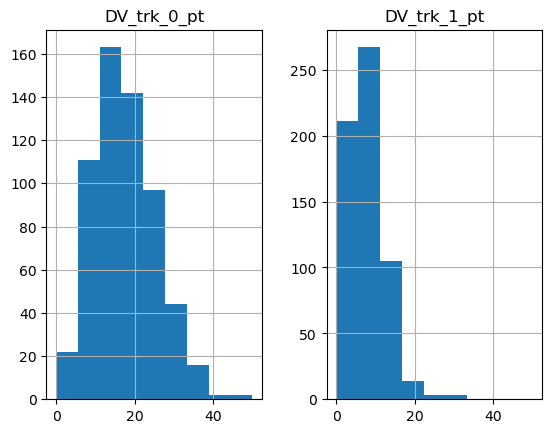

In [43]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
df = uproot.open('/data/hnl/histograms/v9p3_histograms_OS/histograms_mc16a_uue_5G_10mm.root')['nominal_VSI_LeptonsMod_ntuples_LNC_plus_LNV_OS'].pandas.df(['DV_trk_0_pt', 'DV_trk_1_pt'])
df.hist(bins=np.linspace(0,50,10))
plt.show()

In [18]:
df

,DV_ee,DV_emu,DV_mumu
entry,,,
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
596,1.0,0.0,0.0
597,1.0,0.0,0.0
598,1.0,0.0,0.0


In [7]:
glob.glob('/data/hnl/histograms/v9p3_histograms_OS/histograms_mc16a_eee_*.root') + glob.glob('/data/hnl/histograms/v9p3_histograms_OS/histograms_mc16a_uee_*.root')

['/data/hnl/histograms/v9p3_histograms_OS/histograms_mc16a_eee_4p5G_10mm.root',
 '/data/hnl/histograms/v9p3_histograms_OS/histograms_mc16a_eee_3G_10mm.root',
 '/data/hnl/histograms/v9p3_histograms_OS/histograms_mc16a_eee_3G_100mm.root',
 '/data/hnl/histograms/v9p3_histograms_OS/histograms_mc16a_eee_3G_1mm.root',
 '/data/hnl/histograms/v9p3_histograms_OS/histograms_mc16a_eee_4p5G_100mm.root',
 '/data/hnl/histograms/v9p3_histograms_OS/histograms_mc16a_eee_4p5G_1mm.root',
 '/data/hnl/histograms/v9p3_histograms_OS/histograms_mc16a_eee_15G_10mm.root',
 '/data/hnl/histograms/v9p3_histograms_OS/histograms_mc16a_eee_15G_1mm.root',
 '/data/hnl/histograms/v9p3_histograms_OS/histograms_mc16a_eee_15G_100mm.root',
 '/data/hnl/histograms/v9p3_histograms_OS/histograms_mc16a_eee_10G_100mm.root',
 '/data/hnl/histograms/v9p3_histograms_OS/histograms_mc16a_eee_12p5G_10mm.root',
 '/data/hnl/histograms/v9p3_histograms_OS/histograms_mc16a_eee_20G_100mm.root',
 '/data/hnl/histograms/v9p3_histograms_OS/histog